We will perform sentiment analysis with IMDb. The workflow is as follows:
1. EDA & cleaning
2. Baseline linear model
3. LSTM model

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import collections
import itertools
import os

In [35]:
reviews_train = []
for line in open(os.getcwd() + '/data/imbd_train.txt', 'r', encoding='latin1'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open(os.getcwd() + '/data/imbd_test.txt', 'r', encoding='latin1'):
    
    reviews_test.append(line.strip())

In [36]:
target = ["positive" if i < 12500 else "negative" for i in range(25000)]

In [37]:
df1 = pd.DataFrame({"review": reviews_train, "sentiment":target})
df2 = pd.DataFrame({"review": reviews_test, "sentiment":target})

In [38]:
df = pd.concat([df1, df2]).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [39]:
df

,review,sentiment
0,"When I first saw the ad for this, I was like '...",positive
1,"""A Girl's Folly"" is a sort of half-comedy, hal...",positive
2,I started watching the show from the first sea...,positive
3,This is a more interesting than usual porn mov...,positive
4,I suppose for 1961 this film was supposed to b...,negative
...,...,...
49995,I saw this movie at midnight on On Demand the ...,positive
49996,"Some aspects of this production are good, such...",negative
49997,I was not old enough to really appreciate the ...,negative
49998,Nice movie with a great soundtrack which spans...,positive


# 1. EDA & cleaning

In [42]:
sns.countplot(df["sentiment"])

ValueError: could not convert string to float: 'positive'

In [41]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

There is no null data.

### Text cleaning

In [44]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())

In [45]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

# 2. Baseline linear model

Before we build time-consuming neural network model, simple classifier is tried.
Tfidf method is used for text vectorization.

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      6245
           1       0.88      0.91      0.90      6255

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



<Axes: >

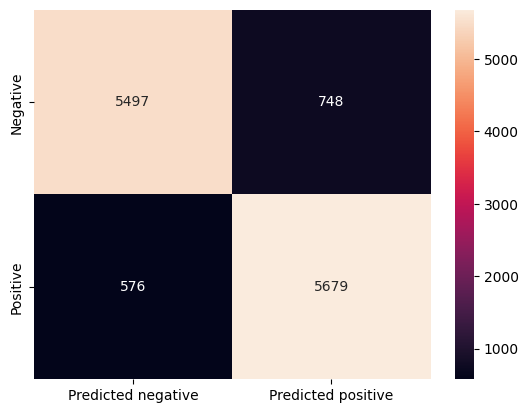

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'].map({'negative':0, 'positive':1}))
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Logistic regression provides 90% accuracy for test set, which is fast and adapted for such large datasets.

# 3. LSTM model

To quickly explore LSTM model, we firstly take only 500 characters. That is much faster way than taking full sentences.

In [47]:
df['review_cleaned_500'] = df['review_cleaned'].apply(lambda x:x[:500])

df['review_cleaned_500'][2]

'i started watching the show from the first season and at the beginning i was pretty skeptical about it original movie was kind of childish and i was just looking for some sci fi show while waiting for the bsg new season but after few episodes i became a fan i ve loved the characters the not so stupid as you think he is jack o neill the not only smart samantha carter the glorious teal c women and kids favorite and brilliant dr daniel jackson of course stories sometimes not serious sometimes even '

### Tokenize & Padding

Let's convert tokens to ID. We will use keras Tokenizer which can filter punctuations and take only most-counted 10000 words.

In [48]:
tokenizer = Tokenizer(num_words=10000)

In [49]:
tokenizer.fit_on_texts(df['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['review_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 116), X_min: 0, X_max: 9999


Sentiment is converted to 0 (negative) or 1 (positive).

In [50]:
y = df['sentiment'].map({'negative' : 0, 'positive' : 1}).values

Let's build the simple LSTM model using first 500 characters datasets.

In [51]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(32000, 116) (8000, 116) (10000, 116) (32000,) (8000,) (10000,)


In [52]:
y_train

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [57]:
embed_size = 64
model = keras.models.Sequential([
    # keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673089 (2.57 MB)
Trainable params: 673089 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1000/1000 [==============================] - 43s 41ms/step - loss: 0.4564 - accuracy: 0.7854 - val_loss: 0.3819 - val_accuracy: 0.8351
Epoch 2/5
 104/1000 [==>...........................] - ETA: 34s - loss: 0.3130 - accuracy: 0.8726

KeyboardInterrupt: 

<AxesSubplot:>

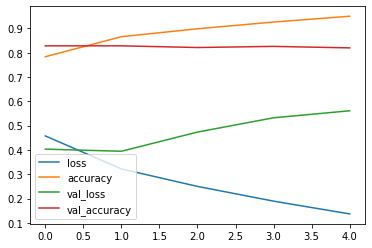

In [16]:
pd.DataFrame(history.history).plot()

This simple model is overfitted with training data as the validation loss increases.

313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4976
           1       0.00      0.00      0.00      5024

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



c:\Users\admin\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<Axes: >

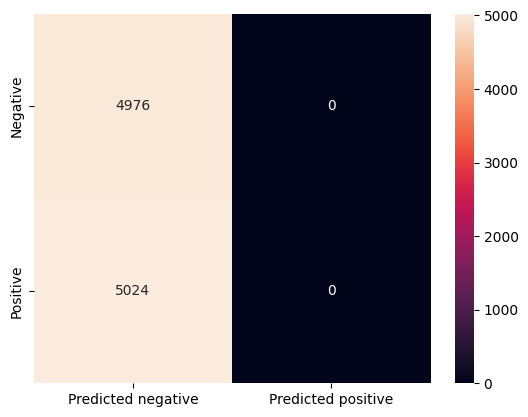

In [56]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Modified LSTM model

We added Dropout layers to prevent overfitting.

In [18]:
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
500/500 [==============================] - 138s 272ms/step - loss: 0.6812 - accuracy: 0.5376 - val_loss: 0.5057 - val_accuracy: 0.7641
Epoch 2/20
500/500 [==============================] - 135s 269ms/step - loss: 0.4742 - accuracy: 0.7870 - val_loss: 0.4150 - val_accuracy: 0.8160
Epoch 3/20
500/500 [==============================] - 135s 270ms/step - loss: 0.3804 - accuracy: 0.8357 - val_loss: 0.3884 - val_accuracy: 0.8259
Epoch 4/20
500/500 [==============================] - 137s 275ms/step - loss: 0.3407 - accuracy: 0.8563 - val_loss: 0.3890 - val_accuracy: 0.8266
Epoch 5/20
500/500 [==============================] - 137s 273ms/step - loss: 0.3138 - accuracy: 0.8686 - val_loss: 0.3768 - val_accuracy: 0.8329
Epoch 6/20
500/500 [==============================] - 135s 271ms/step - loss: 0.2913 - accuracy: 0.8806 - val_loss: 0.3969 - val_accuracy: 0.8319
Epoch 7/20
500/500 [==============================] - 138s 275ms/step - loss: 0.2769 - accuracy: 0.8877 - val_loss: 0.3902 -

<AxesSubplot:>

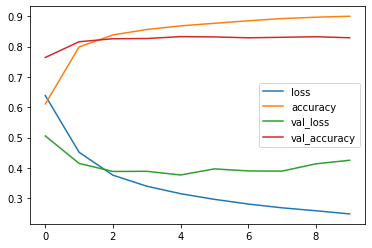

In [20]:
pd.DataFrame(history.history).plot()

Looks better than first model.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4961
           1       0.82      0.86      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



<AxesSubplot:>

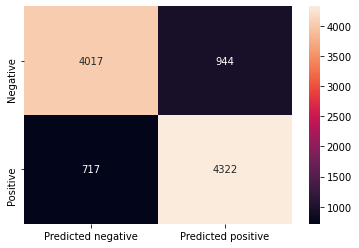

In [21]:
y_pred = model_v2.predict_classes(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Use of full-sentences would increase accurcy. But it is time-consuming and seems difficult to overwhelm simple Logistic regression model.